In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from scipy.stats import norm

In [2]:
df_orig = pd.read_csv('dataset/preprocessed_dataset.csv')
df_proc = df_orig.copy()
df_orig.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,length_ms,frame_count,intensity,zero_crossings_sum,...,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,mean,std,kur,skew
0,1,3,0,0,1,0,3737,179379.0,0.098427,1.121235,...,0.674807,-0.276204,-0.734044,0.175085,0.0,-1.215025,3.844916e-07,0.014482,9.406061,0.706488
1,1,0,0,0,0,0,3904,187387.0,NaN,0.278471,...,0.264372,-0.365037,-0.706940,0.883757,0.0,-1.384174,-7.149491e-08,0.020417,19.564187,0.748262
2,0,4,1,0,1,0,4671,224224.0,0.631165,1.592681,...,0.665423,0.250018,-1.163996,0.879099,0.0,-1.242947,2.429985e-06,0.024317,4.881241,0.771346
3,1,7,0,1,0,0,3637,174575.0,-1.348146,-0.346031,...,0.297811,-0.707183,-0.830636,1.227493,0.0,-1.445318,2.373929e-07,0.003561,13.040259,-0.072032
4,0,4,1,0,1,0,4404,211411.0,0.758500,0.614322,...,0.628032,0.418192,-0.725278,0.811169,0.0,-1.366742,8.454691e-07,0.027522,7.485109,1.018009


In [3]:
emotion_dict = {0: 'angry', 1: 'calm', 2: 'disgust', 3: 'fearful', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprised'}
df_proc['emotion'] = df_proc['emotion'].map(emotion_dict)

one_hot = pd.get_dummies(df_proc['emotion'])
df_proc = df_proc.join(one_hot)
df_proc = df_proc.drop(['emotion'], axis=1)
df_proc.columns

Index(['vocal_channel', 'emotional_intensity', 'statement', 'repetition',
       'sex', 'length_ms', 'frame_count', 'intensity', 'zero_crossings_sum',
       'mfcc_mean', 'mfcc_std', 'mfcc_max', 'sc_mean', 'sc_std', 'sc_min',
       'sc_max', 'sc_kur', 'sc_skew', 'stft_mean', 'stft_std', 'stft_min',
       'stft_kur', 'mean', 'std', 'kur', 'skew', 'angry', 'calm', 'disgust',
       'fearful', 'happy', 'neutral', 'sad', 'surprised'],
      dtype='object')

# stft_min

## Prepare the train-test data

In [4]:
df = df_proc.drop(['sc_min', 'intensity'], axis=1)
df_zero = df[df['stft_min'] == 0]
df_nz = df[df['stft_min'] != 0]

In [5]:
df_train, df_test = train_test_split(df_nz, test_size=0.3, random_state=100)

In [6]:
X_train = df_train.drop(['stft_min'], axis=1).values
y_train = df_train["stft_min"].values

X_test = df_test.drop(['stft_min'], axis=1).values
y_test = df_test["stft_min"].values

## Select the best attributes

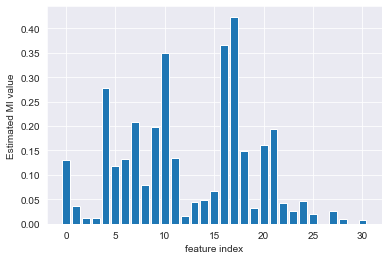

In [7]:
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('feature index')
plt.ylabel('Estimated MI value')
plt.show()

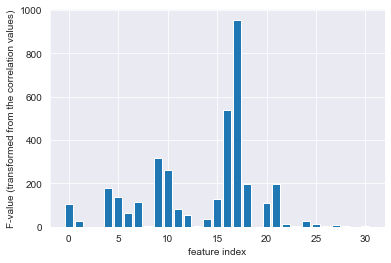

In [8]:
f_selector = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('feature index')
plt.ylabel('F-value (transformed from the correlation values)')
plt.show()

In [9]:
f_selector = SelectKBest(score_func=f_regression, k=10)
# learn relationship from training data
f_selector.fit(X_train, y_train)
# transform train input data
X_train = f_selector.transform(X_train)
# transform test input data
X_test = f_selector.transform(X_test)

## KNN for regression

In [10]:
scaler = MinMaxScaler()
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.fit_transform(X_test)

In [11]:
rmse_val = [np.NaN] # to store rmse values for different k
r2_val = [np.NaN] # to store r-squared values for different k
for k in range(1, 60):
    model = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance')
    model.fit(X_train_scal, y_train)  # fit the model
    y_pred_test = model.predict(X_test_scal) # make prediction on test set

    rmse = math.sqrt(mean_squared_error(y_test, y_pred_test)) # calculate rmse
    rmse_val.append(rmse) # store rmse values

    r_squared = r2_score(y_test, y_pred_test)
    r2_val.append(r_squared)

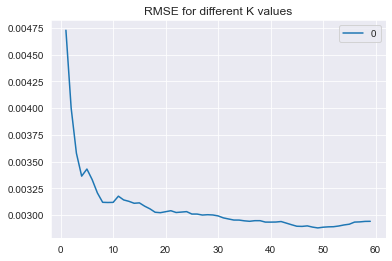

In [12]:
# plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) # elbow curve
curve.plot()
plt.title('RMSE for different K values')
plt.show()

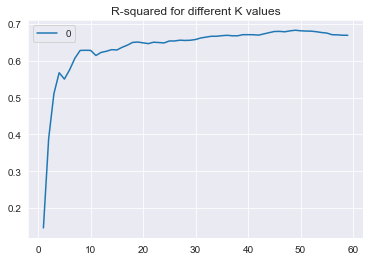

In [13]:
# plotting the r-squared values against k values
curve = pd.DataFrame(r2_val) # elbow curve
curve.plot()
plt.title('R-squared for different K values')
plt.show()

In [14]:
regr = KNeighborsRegressor(n_neighbors=7, weights='distance') #50
regr.fit(X_train_scal, y_train)

KNeighborsRegressor(n_neighbors=7, weights='distance')

In [15]:
y_pred_test = regr.predict(X_test_scal)

In [16]:
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

Root mean squared error = 0.0032
R-squared = 0.6070


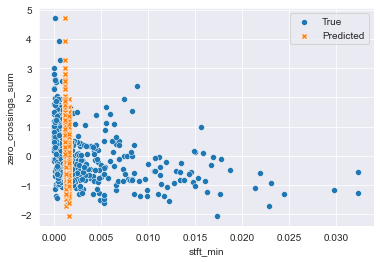

In [17]:
sns.scatterplot(data=df_test, x='stft_min', y="zero_crossings_sum", label="True")
sns.scatterplot(data=df_test, x=regr.predict(X_test), y="zero_crossings_sum", label="Predicted", marker="X")
plt.legend()
plt.show()

In [18]:
X_to_pred = df_zero.drop(['stft_min'], axis=1).values
X_to_pred = f_selector.transform(X_to_pred)
X_to_pred = scaler.fit_transform(X_to_pred)
y_pred = regr.predict(X_to_pred)
y_pred

array([0.00042162, 0.00109067, 0.00018607, ..., 0.01251773, 0.00340162,
       0.00528707])

In [19]:
j = 0
for i in df_orig.index:
    if df_orig.loc[i, 'stft_min'] == 0:
        df_orig.loc[i, 'stft_min'] = y_pred[j]
        j += 1

df_orig['stft_min']

0       0.000422
1       0.001091
2       0.000186
3       0.000893
4       0.000254
          ...   
2416    0.009500
2417    0.012518
2418    0.003402
2419    0.001565
2420    0.005287
Name: stft_min, Length: 2421, dtype: float64

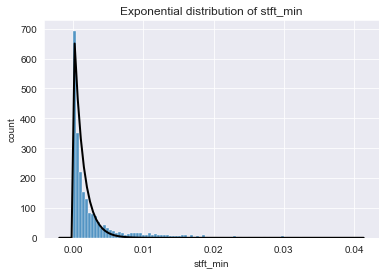

In [20]:
sns.histplot(data=df_orig, x='stft_min', stat='density')
loc = df_orig['stft_min'].min()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.expon.pdf(x, loc=loc, scale=0.0013)

plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('stft_min')
plt.ylabel('count')
plt.title('Exponential distribution of stft_min')
plt.show()

# sc_min

## Prepare the train-test data

In [21]:
df = df_proc.drop(['intensity', 'stft_min'], axis=1)
df_zero = df[df['sc_min'] == 0]
df_nz = df[df['sc_min'] != 0]

In [22]:
df_train, df_test = train_test_split(df_nz, test_size=0.3, random_state=100)

In [23]:
X_train = df_train.drop(['sc_min'], axis=1).values
y_train = df_train["sc_min"].values

X_test = df_test.drop(['sc_min'], axis=1).values
y_test = df_test["sc_min"].values

In [24]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(991, 31) (426, 31) (991,) (426,)


## Select the best attributes

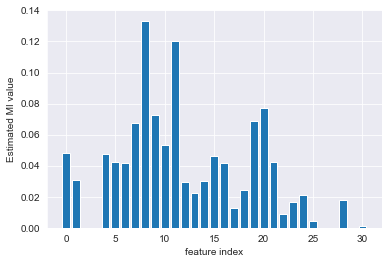

In [25]:
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('feature index')
plt.ylabel('Estimated MI value')
plt.show()

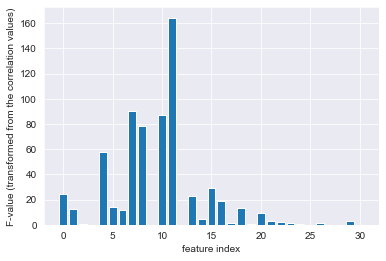

In [26]:
f_selector = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('feature index')
plt.ylabel('F-value (transformed from the correlation values)')
plt.show()

In [27]:
f_selector = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# transform train input data
X_train = f_selector.transform(X_train)
# transform test input data
X_test = f_selector.transform(X_test)

# Linear regression

In [28]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred_test = regr.predict(X_test)

In [30]:
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

Root mean squared error = 178.1847
R-squared = 0.5258


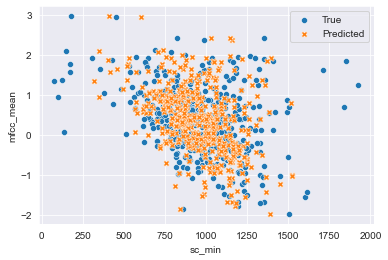

In [31]:
sns.scatterplot(data=df_test, x='sc_min', y='mfcc_mean', label='True')
sns.scatterplot(data=df_test, x=regr.predict(X_test), y='mfcc_mean', label='Predicted', marker='X')
plt.legend()
plt.show()

In [32]:
X_to_pred = df_zero.drop(['sc_min'], axis=1).values
y_pred = regr.predict(X_to_pred)
y_pred

array([1135.46005937,  588.33910806,  881.89822471, ...,  941.66045098,
        490.26438027,  974.55189604])

In [33]:
j = 0
for i in df_orig.index:
    if df_orig.loc[i, 'sc_min'] == 0:
        df_orig.loc[i, 'sc_min'] = y_pred[j]
        j += 1

df_orig['sc_min']

0       1135.460059
1        588.339108
2        881.898225
3        655.131996
4        918.032912
           ...     
2416     807.896177
2417     941.660451
2418     490.264380
2419     760.822547
2420     974.551896
Name: sc_min, Length: 2421, dtype: float64

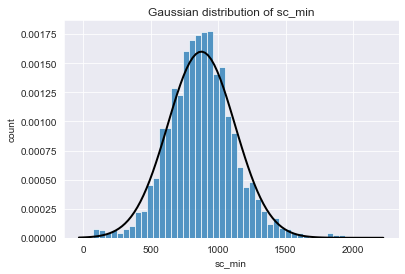

In [34]:
sns.histplot(data=df_orig, x='sc_min', stat='density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, df_orig['sc_min'].mean(),df_orig['sc_min'].std() )

plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('sc_min')
plt.ylabel('count')
plt.title(f'Gaussian distribution of sc_min')
# plt.savefig('sc_min_reg_plot.png')
plt.show()

# intensity
## Prepare the train-test data

In [35]:
df = df_proc.drop(['stft_min', 'sc_min'], axis=1)
df_nan = df[df['intensity'].isna()]
df_not_nan = df[df['intensity'].isna() == False]

In [36]:
df_train, df_test = train_test_split(df_not_nan, test_size=0.3, random_state=100)

In [37]:
X_train = df_train.drop(['intensity'], axis=1).values
y_train = df_train["intensity"].values

X_test = df_test.drop(['intensity'], axis=1).values
y_test = df_test["intensity"].values

In [38]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1129, 31) (485, 31) (1129,) (485,)


# Select the best attributes

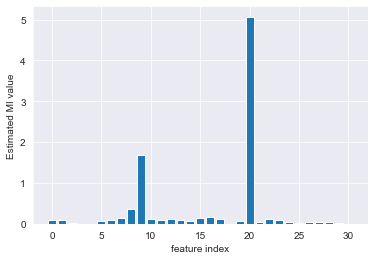

In [39]:
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('feature index')
plt.ylabel('Estimated MI value')
plt.show()

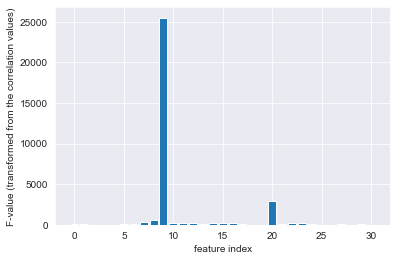

In [40]:
f_selector = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('feature index')
plt.ylabel('F-value (transformed from the correlation values)')
plt.show()

In [41]:
f_selector = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# transform train input data
X_train_fs = f_selector.transform(X_train)
# transform test input data
X_test_fs = f_selector.transform(X_test)

# Linear regression

In [42]:
regr = linear_model.LinearRegression()
regr.fit(X_train_fs, y_train)

LinearRegression()

In [43]:
y_pred_test = regr.predict(X_test_fs)

In [44]:
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

Root mean squared error = 0.1479
R-squared = 0.9774


In [45]:
X_to_pred = df_nan.drop(['intensity'], axis=1).values
X_to_pred = f_selector.transform(X_to_pred)
y_pred = regr.predict(X_to_pred)
y_pred

array([ 3.55530003e-01, -3.08421939e-02,  1.09402248e+00, -2.08954639e-02,
       -1.02332469e+00, -1.57475013e+00,  1.42017218e+00,  1.18377278e+00,
       -1.21066009e-01,  1.53973043e-02,  6.32465840e-01,  9.52237763e-01,
        1.50972619e+00, -4.99249888e-01, -1.64506070e-01, -8.83851920e-01,
       -3.64343841e-01,  1.44472072e-01, -1.58413506e-02,  5.69150260e-01,
        7.42152142e-02,  6.85971512e-01,  9.77300030e-01,  6.23162638e-01,
       -6.04233010e-01,  5.21233152e-01, -1.78462223e-01, -9.87882165e-01,
       -6.85755930e-01, -8.19449418e-01,  1.99727950e-01,  1.30546417e-02,
        1.24247747e-01,  5.81041189e-01, -9.54194769e-01,  7.52333108e-01,
       -1.65376259e+00, -1.10713350e+00,  8.30864359e-01, -1.61269705e-01,
        1.15526950e+00,  1.94507863e+00,  1.59736138e+00, -1.06975786e+00,
       -6.61543326e-01, -1.41320181e+00, -1.23181349e+00, -1.45737708e+00,
        2.79126996e-02,  1.57488319e+00, -6.07180340e-02, -1.75667732e-01,
        7.44070344e-02, -

In [46]:
j = 0
for i in df_orig.index:
    if math.isnan(df_orig.loc[i, 'intensity']):
        df_orig.loc[i, 'intensity'] = y_pred[j]
        j += 1

df_orig['intensity']

0       0.098427
1       0.355530
2       0.631165
3      -1.348146
4       0.758500
          ...   
2416   -1.007230
2417   -0.676477
2418    0.159791
2419   -0.961423
2420   -0.283095
Name: intensity, Length: 2421, dtype: float64

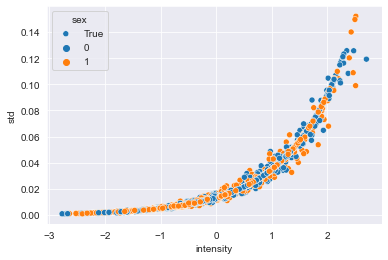

In [47]:
sns.scatterplot(data=df_orig, x='intensity', y='std', hue='sex', label='True')
plt.show()

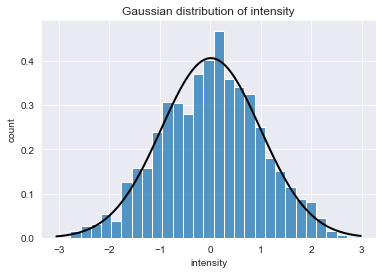

In [48]:
sns.histplot(data=df_orig, x='intensity', stat='density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, df_orig['intensity'].mean(), df_orig['intensity'].std())

plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('intensity')
plt.ylabel('count')
plt.title(f'Gaussian distribution of intensity')
# plt.savefig('intensity_reg_plot.png')
plt.show()

In [49]:
df_orig.corr()['intensity']

vocal_channel         -0.298699
emotion               -0.195014
emotional_intensity    0.387974
statement             -0.043528
repetition             0.026663
sex                   -0.084867
length_ms              0.278577
frame_count            0.204664
intensity              1.000000
zero_crossings_sum     0.487161
mfcc_mean              0.613004
mfcc_std              -0.981713
mfcc_max              -0.392033
sc_mean               -0.332837
sc_std                -0.454571
sc_min                -0.016839
sc_max                -0.197879
sc_kur                 0.395755
sc_skew                0.422208
stft_mean             -0.334278
stft_std               0.237767
stft_min              -0.393293
stft_kur              -0.067188
mean                   0.003907
std                    0.854868
kur                   -0.125630
skew                   0.388009
Name: intensity, dtype: float64

In [50]:
df_orig = df_orig.drop(['intensity'], axis=1)

# Saving the results

In [51]:
df_orig.to_csv('dataset/preprocessed_dataset_after_regression.csv', index=False)